<a href="https://colab.research.google.com/github/yaseeng-md/Plant-Disease-Detector/blob/main/PLANT_DIESEASE_DETECTOR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg19 import VGG19,decode_predictions,preprocess_input
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.models import load_model
!pip install split_folders
import splitfolders
from google.colab import drive
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:

loc = "/content/drive/MyDrive/plantvillage dataset/color"

splitfolders.ratio(loc,output = "modeldataset",seed = 42,ratio = (0.80,.1,.1))

loc = "/content/drive/MyDrive/plantvillage dataset/grayscale"
splitfolders.ratio(loc,output = "modeldataset",seed = 42,ratio = (0.80,.1,.1))

loc = "/content/drive/MyDrive/plantvillage dataset/segmented"
splitfolders.ratio(loc,output = "modeldataset",seed = 42,ratio = (0.80,.1,.1))



Copying files: 10337 files [02:40, 64.54 files/s] 
Copying files: 0 files [00:02, ? files/s]
Copying files: 0 files [00:02, ? files/s]


In [5]:
train_datagen = ImageDataGenerator(zoom_range = 0.5, shear_range = 0.3,horizontal_flip = True,preprocessing_function= preprocess_input)
valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)


In [6]:
train = train_datagen.flow_from_directory(directory= "/content/modeldataset/train",target_size=(256,256), batch_size=32)

valid = valid_datagen.flow_from_directory(directory= "/content/modeldataset/val",target_size=(256,256), batch_size=32)



Found 8266 images belonging to 38 classes.
Found 1029 images belonging to 38 classes.


Building our Model

In [7]:
from keras.layers import Dense,Flatten
from keras.models import Model


In [8]:
base_model = VGG19(input_shape=(256,256,3) , include_top = False )

80134624/80134624 [==============================] - 3s 0us/step


In [9]:
for layer in base_model.layers:
  layer.trainable = False

In [10]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [11]:
from keras.layers.convolutional.base_conv import activations
X = Flatten()(base_model.output)
X = Dense(units = 38, activation = "softmax")(X)

# Model creation
model = Model(base_model.input,X)

In [12]:
model.compile(optimizer="adam",loss = keras.losses.categorical_crossentropy,metrics=["accuracy"])

Early Stooping and Model check Points


In [13]:
#early Stopping
es = EarlyStopping(monitor="val_accuracy",min_delta = 0.01,patience = 3, 
                   verbose = 1)
#model checkpoint
mc = ModelCheckpoint(filepath = "best_model.h5",monitor="val_accuracy",
                     min_delta = 0.01,patience = 3, verbose = 1,
                     save_best_only= True)
cb = [es,mc]



In [14]:
his = model.fit_generator(train ,
                          steps_per_epoch=16,
                          epochs=50,
                          verbose = 1,
                          callbacks=cb,
                          validation_data=valid,
                          validation_steps=16)


<ipython-input-14-2c480d761509>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  his = model.fit_generator(train ,


Epoch 1/50
16/16 [==============================] - ETA: 0s - loss: 13.6871 - accuracy: 0.4492
Epoch 1: val_accuracy improved from -inf to 0.77539, saving model to best_model.h5
16/16 [==============================] - 25s 767ms/step - loss: 13.6871 - accuracy: 0.4492 - val_loss: 5.0286 - val_accuracy: 0.7754
Epoch 2/50
16/16 [==============================] - ETA: 0s - loss: 3.8741 - accuracy: 0.8047
Epoch 2: val_accuracy improved from 0.77539 to 0.90039, saving model to best_model.h5
16/16 [==============================] - 13s 853ms/step - loss: 3.8741 - accuracy: 0.8047 - val_loss: 1.6848 - val_accuracy: 0.9004
Epoch 3/50
16/16 [==============================] - ETA: 0s - loss: 1.9536 - accuracy: 0.8438
Epoch 3: val_accuracy improved from 0.90039 to 0.92383, saving model to best_model.h5
16/16 [==============================] - 14s 889ms/step - loss: 1.9536 - accuracy: 0.8438 - val_loss: 1.3581 - val_accuracy: 0.9238
Epoch 4/50
16/16 [==============================] - ETA: 0s - los

In [15]:
h = his.history
h.keys()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

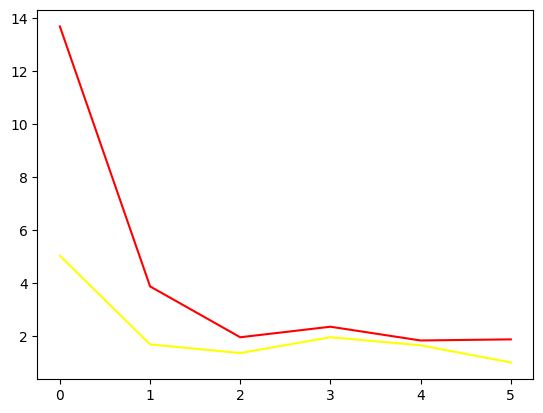

In [16]:
plt.plot(h["loss"] , c = "red")
plt.plot(h["val_loss"] , c = "yellow")




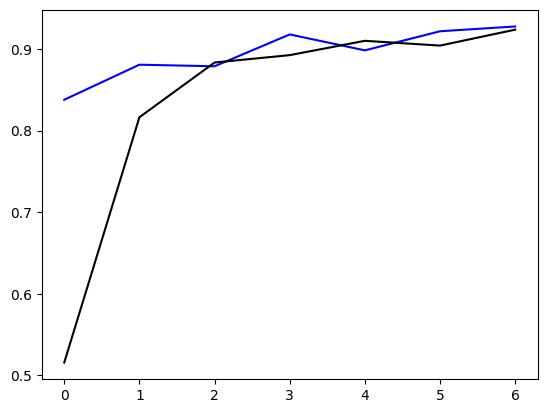

In [39]:
plt.plot(h["val_accuracy"] , c = "blue")
plt.plot(h["accuracy"] , c = "black")


Load Best Model

In [17]:
model = load_model("/content/best_model.h5")

Evaluation of the Model Perfromance

In [18]:
accuracy_of_model = model.evaluate_generator(valid)
print(accuracy_of_model[1]*100)

<ipython-input-18-5606daaeff8b>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  accuracy_of_model = model.evaluate_generator(valid)


93.3916449546814


Accessing the Indices of the Training Data

In [19]:
key_arr = []
for key_name in train.class_indices.keys():
  key_arr.append(key_name)

The Test case of the Project

In [20]:
from keras.utils.image_utils import img_to_array
from keras.utils import load_img
def prediction(path):
  img  = load_img(path,target_size = (256,256))
  i = img_to_array(img)
  im = preprocess_input(i)
  img = np.expand_dims(im , axis = 0)
  pred = np.argmax(model.predict(img))
  print(f"The image belogs to '{key_arr[pred]}' ")

Select the Path of the Image that should be tested and wait for the answer to output

In [22]:
path = "/content/modeldataset/test/Corn_(maize)___Common_rust_/RS_Rust 1576.JPG"
prediction(path)

1/1 [==============================] - 0s 30ms/step
The image belogs to 'Corn_(maize)___Common_rust_' 
